In [1]:
# Importing required modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib notebook


In [ ]:
df = pd.read_csv('dataset1.csv')

# Replace missing values in all columns with mean values
mean_values = df.mean()
df = df.fillna(mean_values)

# M -> +ve, B -> -ve
df['diagnosis'] = df['diagnosis'].replace({'M': 1, 'B': 0})

#remove the 'id' column
df = df.drop('id', axis=1)

# Move column 'diagnosis' to the end
col = df.pop('diagnosis')
df.insert(len(df.columns), 'diagnosis', col)

# Rename column 'diagnosis' to 'Class'
#df = df.rename(columns={'diagnosis': 'Class'})

num_data, num_columns = df.shape
num_features = num_columns - 1
head = [f'feature {i}' for i in range(1, num_columns)] + ['Class']
df.columns = head
df

df

In [ ]:
# define the columns to be normalized
cols_to_normalize = [f'feature {i}' for i in range(1, num_columns)]

# normalize the selected columns using NumPy
df[cols_to_normalize] = (df[cols_to_normalize] - df[cols_to_normalize].mean()) / df[cols_to_normalize].std()

df

# Training and testing data split

In [ ]:
# set a random seed for reproducibility
random_seed = 42

# randomly shuffle the rows of the DataFrame
df = df.sample(frac=1, random_state=random_seed)

# split the DataFrame into training and testing sets
train_size = int(0.67 * len(df))  # set the fraction of data to use for training
train_df = df[:train_size]  # take the first train_size rows for training
test_df = df[train_size:]  # take the remaining rows for testing
train_df

# Generating Features and Class array

In [ ]:
positive_mask = (train_df['Class'] == 1)
pos_points = train_df[positive_mask]
neg_points = train_df[~positive_mask]
num_pos = pos_points.shape[0]
num_neg = neg_points.shape[0]
print(neg_points)

# Starting LDA

In [ ]:
pos_mean = pos_points.mean().to_numpy().reshape((1, -1))[:, :-1]
neg_mean = neg_points.mean().to_numpy().reshape((1, -1))[:, :-1]
pos_mean

In [7]:
pos_points = pos_points.drop(['Class'], axis=1)
neg_points = neg_points.drop(['Class'], axis=1)
pos_diff = pos_points - pos_mean
neg_diff = neg_points - neg_mean

In [ ]:
pos_diff = pos_diff.to_numpy()
neg_diff = neg_diff.to_numpy()
pos_diff

# Getting Covariance Matrix

In [ ]:
pos_sum = np.zeros((num_features, num_features))
neg_sum = np.zeros((num_features, num_features))

for x in pos_diff:
    x = x.reshape((1, -1))
    pos_sum += np.matmul(x.T, x)
for x in neg_diff:
    x = x.reshape((1, -1))
    neg_sum += np.matmul(x.T, x)

cov_matrix = pos_sum / num_pos + neg_sum / num_neg
cov_matrix

In [10]:
cov_matrix.shape

(30, 30)

# Getting Weight Array

In [ ]:
w = np.matmul(np.linalg.inv(cov_matrix), (pos_mean - neg_mean).T)
w = w / np.linalg.norm(w)
w

In [12]:
w.shape

(30, 1)

In [ ]:
# Finding projection of classes
project_pos = np.dot(pos_points.to_numpy(), w.flatten())
project_neg = np.dot(neg_points.to_numpy(), w.flatten())
print(project_pos.shape)

# Function to find intersection of two normal curves

In [14]:
def solve(m1,m2,std1,std2):
    a = 1/(2*std1**2) - 1/(2*std2**2)
    b = m2/(std2**2) - m1/(std1**2)
    c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1)
    return np.roots([a,b,c])

# Finding the Intersection

In [15]:
positive_mean = project_pos.mean()
negative_mean = project_neg.mean()
positive_std = project_pos.std()
negative_std = project_neg.std()

result = solve(positive_mean, negative_mean, positive_std, negative_std)
result = result[1]

# Visualizing the results

<IPython.core.display.Javascript object>


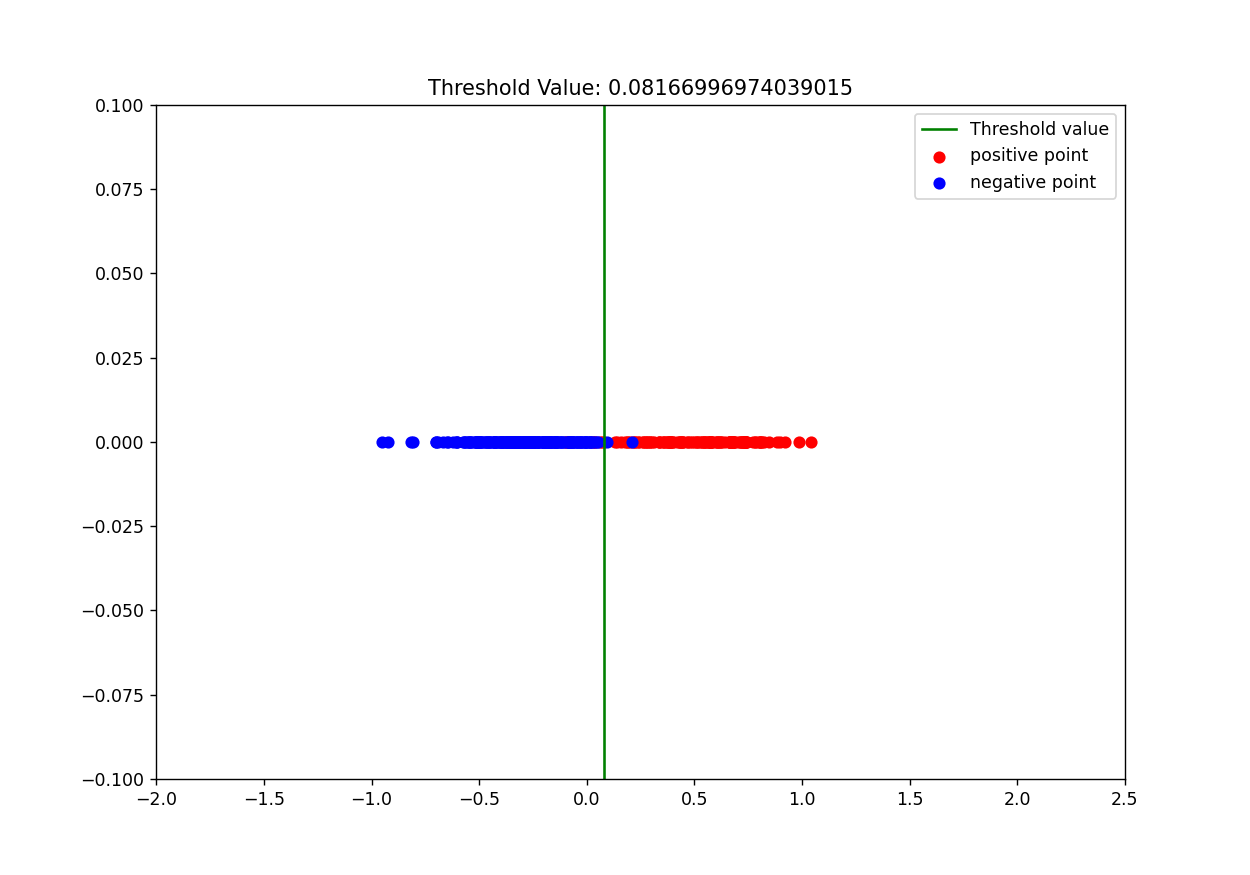

In [16]:
arrp = np.zeros((len(project_pos)))
arrn = np.zeros((len(project_neg)))

plt.figure(figsize = (10,7))
plt.title(f'Threshold Value: {result}')
plt.scatter(project_pos, arrp, color = 'red', label = 'positive point')
plt.scatter(project_neg, arrn, color = 'blue', label = 'negative point')
yp = np.linspace(-0.1, 0.1, 1000)
xp = result * np.ones((1000))
plt.plot(xp, yp*1000, color = 'green', label = 'Threshold value')
plt.ylim(-0.1, 0.1)
plt.xlim(-2, 2.5)
plt.legend();

<IPython.core.display.Javascript object>


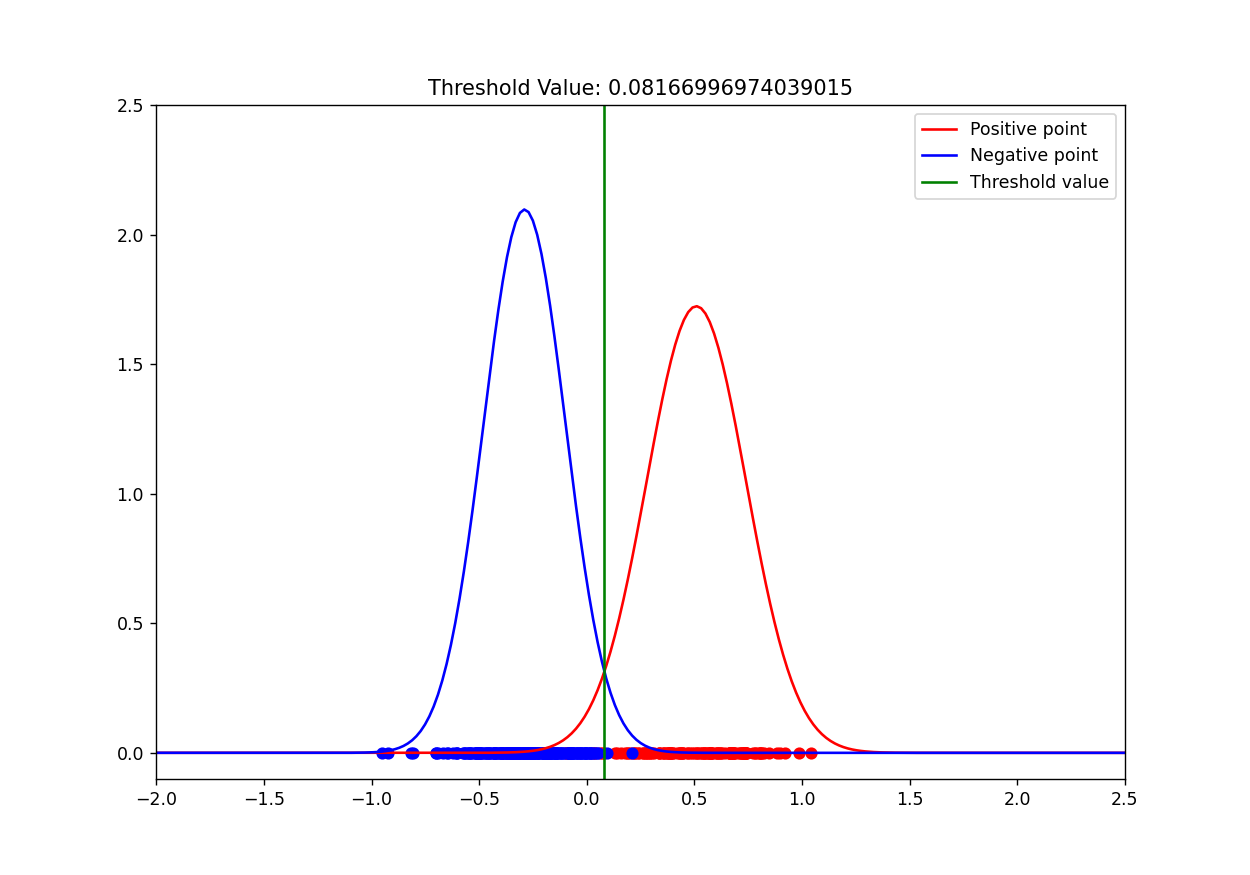

In [17]:
x = np.linspace(-5, 5, 500)
ptemp = np.zeros((len(project_pos), 1))
ntemp = np.zeros((len(project_neg), 1))

plt.figure(figsize = (10,7))
plt.title(f'Threshold Value: {result}')
plt.plot(x, norm.pdf(x, positive_mean, positive_std), color = 'red', label = 'Positive point')
plt.plot(x, norm.pdf(x, negative_mean, negative_std), color = 'blue', label = 'Negative point')

plt.scatter(project_pos, ptemp, color = 'red')
plt.scatter(project_neg, ntemp ,color = 'blue')

yp = np.linspace(-0.1, 0.1, 1000)
xp = result * np.ones((1000))
plt.plot(xp, yp*1000, color = 'green', label = 'Threshold value')
plt.ylim(-0.1, 2.5)
plt.xlim(-2, 2.5)
plt.legend();

# Testing the model with training and testing data

In [18]:
pred_pos_dataset = pd.DataFrame(project_pos)
pred_neg_dataset = pd.DataFrame(project_neg)

pred_pos_dataset = pred_pos_dataset.values
pred_neg_dataset = pred_neg_dataset.values

ptemp = np.zeros((len(pred_pos_dataset), 1))
ntemp = np.zeros((len(pred_neg_dataset), 1))
pred_pos = np.append(pred_pos_dataset, ptemp, axis=1)
pred_neg = np.append(pred_neg_dataset, ntemp, axis=1)

tp=0
tn=0
fp=0
fn=0
for i in range(len(pred_pos_dataset)):
  if pred_pos[i, 0] < result:
    pred_pos[i, 1] = 0
    fn+=1
  else:
    pred_pos[i, 1] = 1
    tp+=1

for i in range(len(pred_neg_dataset)):
  if pred_neg[i, 0] < result:
    pred_neg[i, 1] = 0
    tn+=1
  else:
    pred_neg[i, 1] = 1
    fp+=1
    
accuracy = (tp+tn)/(tp+tn+fp+fn)
Recall = tp/ (tp + fn)
Precision = tp/ (tp + fp)
print(f'Accuracy of the model with testing is {accuracy * 100}')
print(f'Recall of the model with testing is {Recall * 100}')
print(f'Precision of the model with testing is {Precision * 100}')

Accuracy of the model with testing is 97.3753280839895
Recall of the model with testing is 94.11764705882352
Precision of the model with testing is 98.46153846153847


In [19]:
positive_mask = (test_df['Class'] == 1)
pos_points = test_df[positive_mask]
neg_points = test_df[~positive_mask]
num_pos = pos_points.shape[0]
num_neg = neg_points.shape[0]
print(neg_points.shape)

(112, 31)


In [20]:
pos_points = pos_points.drop(['Class'], axis=1)
neg_points = neg_points.drop(['Class'], axis=1)


In [21]:
# Finding projection of classes
project_pos = np.dot(pos_points.to_numpy(), w.flatten())
project_neg = np.dot(neg_points.to_numpy(), w.flatten())
print(project_pos)

[ 0.46546247  0.3366026   0.55426028  0.24865036  0.26491838  0.21166944
  0.73969493  0.25804577  0.11690911  0.60152608  0.56542835  0.6869738
  0.42744701  0.08458258  0.03082597  0.36373557  0.74342213  0.67811469
  0.75507272  0.44704865  0.51664899  0.17689579  0.24723433  0.19441064
  0.33251408  0.10324432  0.46596591  0.62970644  0.83410841  0.54156468
  0.6064463   0.464161    0.61549803  0.79742047  0.47726832  0.92787494
  0.3509841   0.03715751  0.207409    0.46735168  0.88516249  0.13730356
  0.29809268 -0.03108672  0.13931482  0.68208066  0.82843665  0.29056147
  0.45930109  0.34396815  0.22498788  0.39192316  0.55268821  0.29604226
  0.07688535  0.6645185   0.51237789  0.59845431  0.57879278  0.16999398
  0.50881799  0.90201809  0.15244195  0.7820947   0.11799133  0.70928938
  1.02602317  0.22992519  0.80211488  0.15729784  0.41532519  1.05681693
  0.25260035  0.61103446  0.57430637  0.39102666]


In [22]:
pred_pos_dataset = pd.DataFrame(project_pos)
pred_neg_dataset = pd.DataFrame(project_neg)

pred_pos_dataset = pred_pos_dataset.values
pred_neg_dataset = pred_neg_dataset.values

ptemp = np.zeros((len(pred_pos_dataset), 1))
ntemp = np.zeros((len(pred_neg_dataset), 1))
pred_pos = np.append(pred_pos_dataset, ptemp, axis=1)
pred_neg = np.append(pred_neg_dataset, ntemp, axis=1)

tp=0
tn=0
fp=0
fn=0
for i in range(len(pred_pos_dataset)):
  if pred_pos[i, 0] < result:
    pred_pos[i, 1] = 0
    fn+=1
  else:
    pred_pos[i, 1] = 1
    tp+=1

for i in range(len(pred_neg_dataset)):
  if pred_neg[i, 0] < result:
    pred_neg[i, 1] = 0
    tn+=1
  else:
    pred_neg[i, 1] = 1
    fp+=1

accuracy = (tp+tn)/(tp+tn+fp+fn)
Recall = tp/ (tp + fn)
Precision = tp/ (tp + fp)
print(f'Accuracy of the model with testing is {accuracy * 100}')
print(f'Recall of the model with testing is {Recall * 100}')
print(f'Precision of the model with testing is {Precision * 100}')

Accuracy of the model with testing is 96.80851063829788
Recall of the model with testing is 94.73684210526315
Precision of the model with testing is 97.2972972972973
